In [2]:
import numpy as np, cv2, os
from matplotlib import pyplot as plt
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

***
# 1. Singular value decomposition
Here you will learn rough description on SVD some knobs and buttons. More in-depth example in clustering NB.

Additonal resources: 
* theory in notebook /Clustering/SVD_PCA_Clustering_brunton_ch_05_pt1.ipynb (image stack processing)
* https://statomics.github.io/HDA2020/svd.html

## 1.1 Definition: Full SVD

SVD is a matrix factorization algorithm, which decomposes matrix 
$X$ into sequence of **abstract** transformations: 
1. rotation $U$;
2. scaling $\Sigma$;
3. rotation $V^*$

as $X = U \Sigma V^*$

where operator (*) is conjugate transpose (in code we will denote $V^*$ as `Vh`, h for Hermitian transpose).

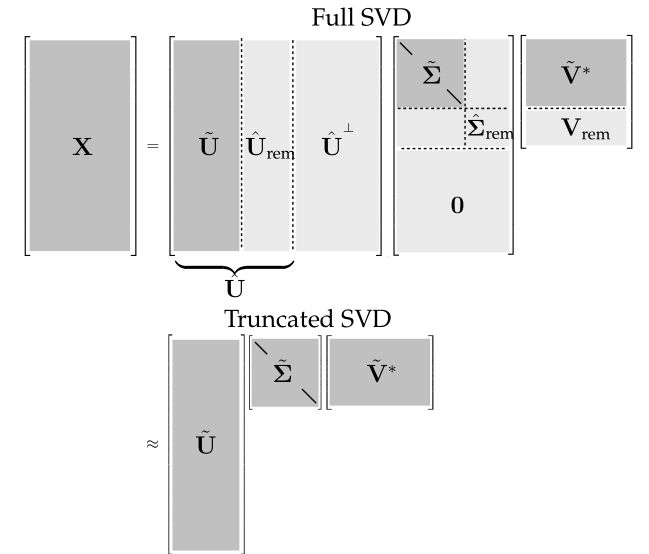

Rotation and scaling transformations can be viewed in a similar fashion as in <i>eigendecomposition</i>.

In eigendecomposition we extract eigenvectors (/features/basis vectors) of a square matrix along which data varies the most, and eigenvalues representing basis contribution.

In case of SVD we can think of columns of matrices $U$ and $V$ (rows of $V^*$) as eigenvectors (of rows and columns of $X$<i>, which can be interpreted differently depending on how $X$ is constructed</i>).

<i>IMO, transformations and transformed basis vectors are related, but only when dealing in ortonormal spaces, which is why we think of transformations in abstract terms </i>

Singular values (analog of eigenvalues) are stored in matrix $\Sigma$ as diagonal elements.<br>
$\sigma_i = (\Sigma)_{ii}$ are non-negative and ordered in descending order.<br>
This constraint of representation makes SVD factorization unique, and is very important for determining dominant basis vectors.

## 1.2 Definition: Compact and Truncated SVD

Matrix $\Sigma$ contains only limited number of non-zero rows, when reconstructing, portion of rows of $U$ and columns on $V^*$ are multiplied by 0, thus can be neglected.

i.e if $\Sigma$ has $k$ non-zero rows. By storing only first $k$ columns of $U$ and only first $k$ rows of $V^*$, we get a **compact** factorized representation.

>Here is an example of full and compact SVD factorization:

In [11]:
np.random.seed(69)
frmt = '{:.3f}'
X = np.random.rand(5,2)

print_tex('X_{true} = ', X, frmt = frmt)
U, S, Vh = np.linalg.svd(X,full_matrices=True)  # S is list of diag elements, not a matrix
S_rect = np.zeros_like(X)                       # proper sized primer matrix.
S_rect[:len(S),:len(S)] = np.diag(S)

X_reconstruct_full = U @ S_rect @ Vh
print_tex(r'X \sim U \Sigma V^*', '=', U , S_rect , Vh,'=', X_reconstruct_full, frmt = frmt)
print(f'Reconstruction full match: {np.allclose(X_reconstruct_full, X)}')
U_hat, S_hat, Vh_hat = np.linalg.svd(X, full_matrices=False)
X_reconstructed_hat = U_hat@np.diag(S_hat) @ Vh_hat
print_tex(r'X \sim \tilde U \tilde\Sigma \tilde V^*', '=', U_hat , np.diag(S_hat) , Vh_hat,'=', X_reconstructed_hat, frmt = frmt)
print(f'Reconstruction compact match: {np.allclose(X_reconstructed_hat, X)}')

#print(f'{U.shape = }, {S_rect.shape = }, {Vh.shape = },  {np.linalg.matrix_rank(S_rect) = }')
#print(f'{U_hat.shape = }, {np.diag(S_hat).shape = }, {Vh_hat.shape = }') 


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Reconstruction full match: True


<IPython.core.display.Math object>

Reconstruction compact match: True


Differences between reconstruction and true matrix can be calculated using Frobenius norm
$$||A||_F = \sqrt{\sum_{i,j} |a_{ij}|^2}$$

In [4]:
norm_full   = np.linalg.norm(X - X_reconstruct_full, ord = 'fro')
norm_comp   = np.linalg.norm(X - X_reconstructed_hat, ord = 'fro')
print(f' {norm_full = }\n {norm_comp = }')

 norm_full = 1.6725469333392293e-16
 norm_comp = 1.6725469333392293e-16


## 1.2 Data (image) compression via further $U \Sigma V^*$ truncation

Since singular values $\sigma_i$ are ordered in decreasing manner, we can trim up to first `r` values, along with respective columns of $U$ and rows of $V^*$.

Truncating reduces amount of stored information, but also reduce reconstruction quality.

U.shape = (2000, 2000), S.shape = (1500,), Vh.shape = (1500, 1500)
OG shape: (2000, 1500) and total # of elements =  3000000
r = 100; shapes:((2000, 100), (100, 100), (100, 1500)) = 360000 elements in total = 12.0 % of original
r = 20 ; shapes:((2000, 20), (20, 20), (20, 1500)) = 70400 elements in total = 2.3 % of original
r = 5  ; shapes:((2000, 5), (5, 5), (5, 1500)) = 17525 elements in total = 0.6 % of original


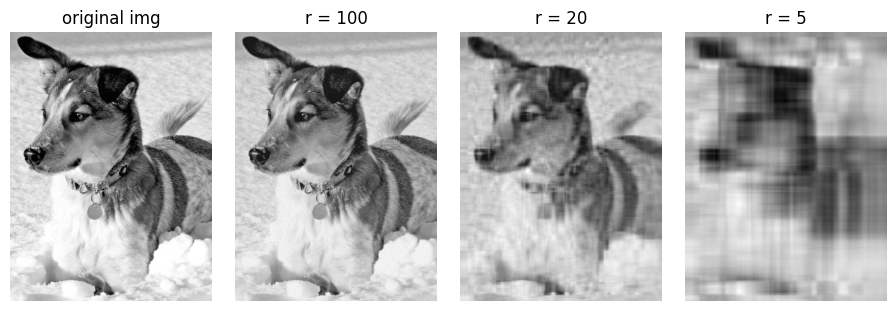

In [5]:
img = np.array(cv2.imread(os.path.join('data_processing','media','dog.jpg'), 0), float)
U,S,Vh = np.linalg.svd(img,full_matrices=True)

print(f'{U.shape = }, {S.shape = }, {Vh.shape = }')
fig, ax = plt.subplots(1,4, layout='constrained',figsize = (9,3))
ax = ax.reshape(ax.size)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('original img', fontsize=12)
ax[0].axis('off')
print('OG shape:', img.shape, 'and total # of elements = ', img.size)
for i,r in enumerate([100, 20, 5]):
    U_trunk = U[:,:r]           # all rows up to r columns
    S_trunk = np.diag(S[:r])    # first r diagonal entries
    Vh_trunk = Vh[:r,:]         # all columns, up to r rows
    total_size = U_trunk.size + S_trunk.size + Vh_trunk.size
    print(f'r = {r:<3}; shapes:{U_trunk.shape, S_trunk.shape, Vh_trunk.shape} = {total_size} elements in total = {total_size/img.size* 100 :.1f} % of original')
    approx = U_trunk @ S_trunk @ Vh_trunk
    ax[i + 1].imshow(approx, cmap='gray')
    ax[i + 1].set_title(f'r = {r}', fontsize=12)
    ax[i + 1].axis('off')

What are the options of selecting truncation size?

>In the easiest case we can plot all singular values or plot normalized cumulative 'energy' and do truncation based on energy threshold

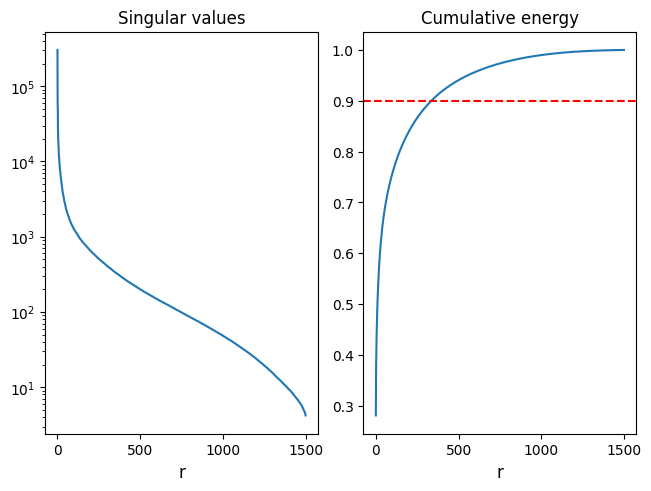

In [6]:
fig, ax2 = plt.subplots(1,2, layout='constrained', sharex=True)
ax2[0].semilogy(S)
ax2[0].set_title('Singular values', fontsize=12)
ax2[0].set_xlabel('r', fontsize=12)
ax2[1].plot(np.cumsum(S)/np.sum(S))
ax2[1].set_title('Cumulative energy', fontsize=12)
ax2[1].set_xlabel('r', fontsize=12);
ax2[1].axhline( y= 0.9,c = 'r', ls = '--');

## 1.3 $U$ and $V^*$ matrices are unitary and $\Sigma$ is diagonal, why is it good?
Unitary $U$ and diagonal $D$ matrices are easily invertible:
$$U^*U = UU^* = I \rightarrow U^{-1} = U^*$$
$$(D^{-1})_{i,j} = 1/(D)_{i,j}$$

Easy inversion is beneficial for solving linear matrix equations (even with non-square matrices), such is the case of linear regression.

### 1.3.1 1D Linear Regression

If we are given a problem $$ A \vec{x} = b $$, we can approximate solution x by $$\vec{x} \approx A^{-1} b$$ 

Note: or we can write an equality `=` by introducing approximation error $\vec{\epsilon}$ $$\vec{x} = A^{-1} b + \vec{\epsilon}$$

Lets consider that given data $\{x_i,y_i\}_{i=1}^n$ can be modeled via linear model 
$$y(x) = s*x$$

$$
\begin{cases}
y_1  = s * x_1 \\ y_2  = s * x_2 \\ \vdots \\ y_n  = s * x_n
\end{cases}
\rightarrow
\begin{bmatrix}
y_1 \\ y_2\\ \vdots \\ y_n
\end{bmatrix}=
\begin{bmatrix}
x_1 \\ x_2\\ \vdots \\ x_n
\end{bmatrix}
s
\rightarrow 
\vec{y} = \vec{x} s
$$
We can solve $\vec{y} = \vec{x} s$ by 'inverting' $\vec{x}$
$$s = \vec{x}^{-1}\vec{y}$$

Which can be done by factorizing $$\vec{x} = U \Sigma V^*$$

$$ \vec{x}s = \vec{y} \rightarrow (U \Sigma V^*)s = \vec{y}$$
Multiply by $ V \Sigma^{-1} U^* \cdot$ on the left
$$ (V \Sigma^{-1} U^*) (U \Sigma V^*) s = (V \Sigma^{-1} U^*) \vec{y} $$
$$ (V \Sigma^{-1}) U^*U (\Sigma V^*) s = (V \Sigma^{-1}) I (\Sigma V^*) s = V (\Sigma^{-1}\Sigma )V^* s=  VV^*s = s = (V \Sigma^{-1} U^*) \vec{y}$$

So
$$s = (V \Sigma^{-1} U^*) \vec{y} = M \vec{y}$$

*** 
### 1.3.1.1 Note
* this inverse produces least squares solution
* truncated $U$ and $V$ might not be square. If so, $U^TU \neq V^TV \neq I$

We saw in truncation example `1.2` that matrix $X$ is of dimensions $n \times r $ (tall-skinny, overconstrained = overdetermined)<br>
truncated matrix $U$ is $n \times r$ and $V^T$ is $r \times r$. So $U^TU \neq I$ and $V^TV = I$.

$$\vec{x} = U \Sigma V^* \ ; \ s = (V \Sigma^{-1} U^*) \vec{y}$$

$$\vec{y} = \vec{x} s \approx ( U \Sigma V^*)(V \Sigma^{-1} U^*) \vec{y} = U U^* \vec{y}$$

$$\vec{y} = \vec{x} s =  U U^* \vec{y} + \vec{\epsilon} \rightarrow \vec{\epsilon} = (I - U U^*) \vec{y}  $$

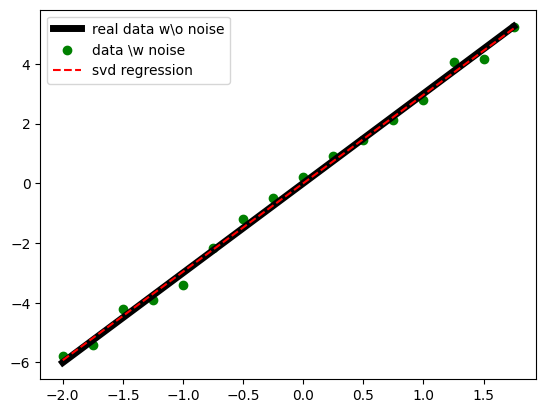

In [8]:
np.random.seed(69)
s_true = 3
x = np.arange(-2.0, 2.0, 0.25).reshape(-1,1)    # domain
noise = 0.25*np.random.randn(*x.shape)          # generate noise (gaussian)
y = s_true*x + noise                            # gen linearly related data

U, S, Vh = np.linalg.svd(x,full_matrices=False)

Uh,S_inv,V = U.T, 1/np.diag(S), Vh.T

M = V @ S_inv @ Uh
s_guess =  M @ y

plt.plot(   x, s_true*x     , c='k', label='real data w\o noise', lw = 5)
plt.scatter(x, y            , c='g', label='data \w noise')
plt.plot(   x, s_guess * x  , c='r', label='svd regression', linestyle='--')
plt.legend();

## 1.4 Principle Component Analysis (PCA) and its relation to SVD
### 1.4.1 What is PCA?
PCA is a dimensionality reduction technique which tries find representation of n-dimensional data in such orthogonal axis, which can explain the most variance (when projected onto this new basis).

This can be stated simpler:<br> 
    <i>Might think that length of a vector is a limited resource.</i><br>
    We want to find a direction of first principle component (basis/axis), which will 'gather' more data projections.


***

In the following example we will see what  'high variance' or 'spread' over principle components means.

><i>Generate data points and compare projections onto different basis.<br>
>Alternatively you can generate data, rotate it and test projections in original cartesian system</i>

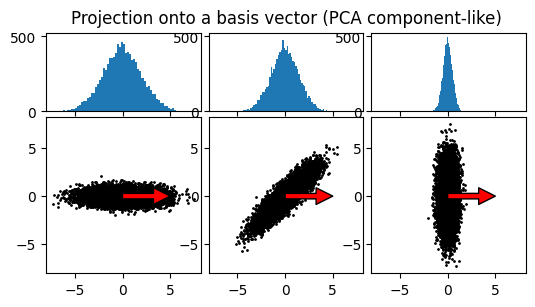

In [9]:
def rotation_matrix(angle):
    return np.array([
                    [np.cos(angle),    -np.sin(angle)],
                    [np.sin(angle),     np.cos(angle)] ])

center = np.array([2,1])
scaling = np.array([2,0.5])
angles = [0,np.deg2rad(45),np.deg2rad(90)]
num_points = 10000
pts = []

fig = plt.figure(figsize=(6, 3))

gs = fig.add_gridspec(2, len(angles),  height_ratios=(2, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

n_gaussians = np.diag(scaling) @ np.random.normal(size=(2, num_points)) 

top     = []
bottom = []
fig.suptitle('Projection onto a basis vector (PCA component-like)')
for i, angle in enumerate(angles):
    
    x,y = rotation_matrix(angle) @ n_gaussians
    sharexy = bottom[-1] if i > 0 else None
    ax = fig.add_subplot(gs[1, i], sharex = sharexy, sharey = sharexy)
    
    ax.scatter(x, y, s = 1, c = 'k')
    ax.annotate('', (5,0), xytext=(0,0), arrowprops=dict(facecolor='red'))
    
    bins    = np.linspace(np.min(x), np.max(x), 70 + 1)
    sharey = top[-1]  if i > 0 else None
    ax_histx = fig.add_subplot(gs[0, i], sharex=ax, sharey=sharey)
    ax_histx.hist(x, bins=bins)#, weights=np.abs(y)
    ax_histx.tick_params(axis='both', labelbottom=False)
    top.append(ax_histx)
    bottom.append(ax)
    

Highest variance occurs along the dimension which is aligned with data!

### 1.4.2 What is PCA's relation with SVD?
> Lets generate data and transform it via rotation, scaling and translation. Take notice of transformation matrices.

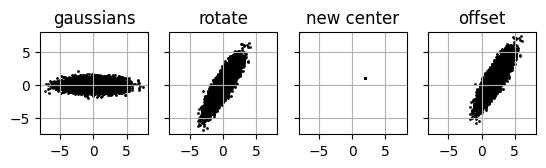

In [13]:
plt.rcParams['axes.grid'] = True
center = np.array([2,1])
scaling = np.array([2,0.5])

theta = np.pi/3

M_rot = rotation_matrix(theta)

num_points = 10000
n_centers = np.diag(center) @ np.ones((2,num_points))                   
n_gaussians = np.diag(scaling) @ np.random.normal(size=(2, num_points)) 
n_gauss_rot = M_rot @ n_gaussians
X = n_gauss_rot + n_centers
fig, ax = plt.subplots(1,4, sharex=True, sharey=True)
#ax = ax.reshape(ax.size)
titles = ['gaussians','rotate','new center', 'offset']
for i, pts in enumerate([ n_gaussians, n_gauss_rot, n_centers, X]):
    ax[i].scatter(pts[0,:]    , pts[1,:], s = 1, c = 'k')
    ax[i].set_aspect(1)
    ax[i].set_title(titles[i])


In order to apply SVD for this data, we have to:
* `nullify global bias - offset`
* `normalize data` (presumably dividing by sqrt(num_data) brings variance close to 1)

Observe that $U$ and $\Sigma$ matrices are related to data rotation matrix and gaussian scaling (confidence intervals).

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

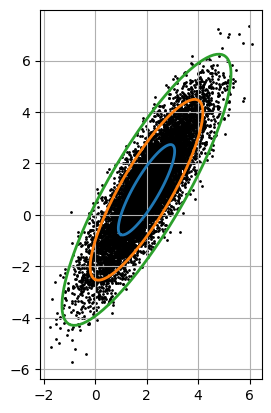

In [14]:
X_avg = np.mean(X,axis=1)
X_offsets = np.diag(X_avg) @ np.ones((2,num_points))     

B = X - X_offsets

U,S,V = np.linalg.svd(B/np.sqrt(num_points), full_matrices=False)

print_tex('offsets:', X_offsets[:,:3])
print_tex(r'M_{rot}=',M_rot,',U=',U)
print_tex('STDEVS=',scaling, ', S_{elements}=',S)


# draw bands by deforming points forming a circle using S value scales
thetas = 2*np.pi * np.arange(0,1,0.01)
ellipse = np.diag(S) @ np.array([np.cos(thetas), np.sin(thetas)])
# rotate by U, offset to X_avg during plot
X_std = U @ ellipse

fig, ax2 = plt.subplots(1,1, sharex=True, sharey=True)
ax2.scatter(X[0,:]    , X[1,:], s = 1, c= 'k')
for k in [1,2,3]:
    ax2.plot(X_avg[0] + k* X_std[0,:]   , X_avg[1] + k* X_std[1,:], lw= 2)
ax2.set_aspect(1)

truncating. generate problem with known rank (rank = 2). we can then apply theory for cases where noise level is known

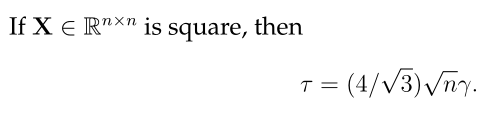

energy at entries r and r + 1 0.8990420302755474 0.9000559790196997


Text(0.5, 1.0, 'truncated SVD by 90% energy')

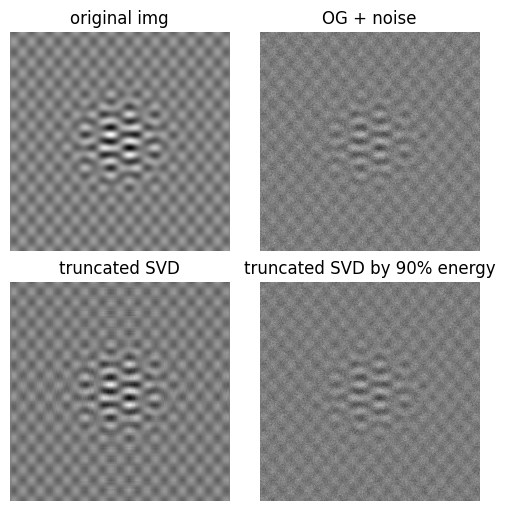

In [15]:
t = np.arange(-3,3,0.01)
Utrue = np.array([
                    np.cos(17*t)*np.exp(-t**2), 
                    np.sin(11*t)
                ])

Strue = np.diag([2, 0.5])

Vtrue = np.array([
                    np.sin(5*t)*np.exp(-t**2),
                    np.cos(13*t)
                ])

X = Utrue.T @ Strue @ Vtrue

fig, ax = plt.subplots(2,2, layout='constrained', figsize = (5,5))
ax = ax.reshape(ax.size)
ax[0].imshow(X, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('original img', fontsize=12)

gamma = 1;
noise = gamma*np.random.randn(*X.shape)
X_noise = X + noise

ax[1].imshow(X_noise, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('OG + noise', fontsize=12)

cutoff = (4/np.sqrt(3)) * np.sqrt(t.size) * gamma

U,S,V = np.linalg.svd(X_noise, full_matrices=False)

r = np.max(np.where(S>cutoff)) + 1  # counting form zero
X_trunk = U[:,:r] @ np.diag(S[:r]) @ V[:r,:]

ax[2].imshow(X_trunk, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('truncated SVD', fontsize=12)

#cumulative energy
en = np.cumsum(S)/np.sum(S)
r2 = np.max(np.where(en < 0.9))
print('energy at entries r and r + 1',en[r2], en[r2 + 1])
X_90en = U[:,:r2] @ np.diag(S[:r2]) @ V[:r2,:]

ax[3].imshow(X_90en, cmap = 'gray')
ax[3].axis('off')
ax[3].set_title('truncated SVD by 90% energy', fontsize=12)

Text(0.5, 1.0, 'total energy and and trankation thresholds')

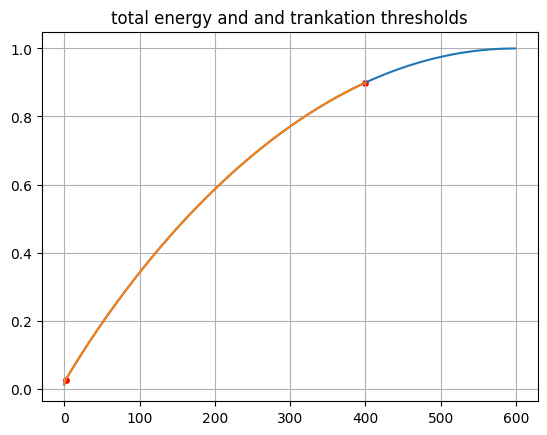

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(en)
ax.plot(en[:r2+1])
ax.scatter([r], [en[r]], s = 15, c = 'r')
ax.scatter([r2], [en[r2]], s = 15,  c = 'r')
ax.set_title('total energy and and trankation thresholds')


data for SVD should be well aligned. for example pictures of faces should be cropped so different features have same relative position

in this example we generate a rank 2 matrix (2 independent columns)

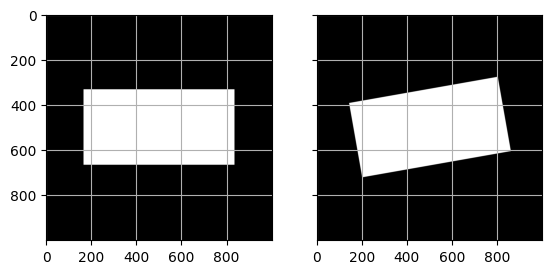

In [ ]:
n = 1000

forth = n//3
sixt = n//6

# OG way
X = np.zeros((n,n))
X[forth:-forth,forth:-forth] = 1

# using outer product of eigen vectors 
rowX = np.zeros(n)
rowX[forth:-forth] = 1
colY = np.zeros(n)
colY[sixt:-sixt] = 1

X = np.outer(rowX,colY)

M_rot_img = cv2.getRotationMatrix2D((n//2, n//2), 10, 1.0)
X_rot = cv2.warpAffine(X, M_rot_img, X.shape)
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].imshow(X      , cmap='gray')
ax[1].imshow(X_rot  , cmap='gray')

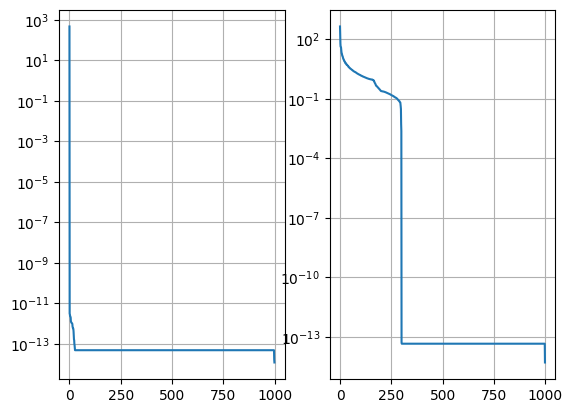

In [ ]:
U,S,V       = np.linalg.svd(X       , full_matrices=True)
U2,S2,V2    = np.linalg.svd(X_rot   , full_matrices=True)
fig, ax = plt.subplots(1,2, sharex=True, sharey=False)
ax[0].semilogy(S)
ax[1].semilogy(S2)

In [ ]:
def rsvd(X,r,q,p):
    # Step 1: Sample column space of X with P matrix
    ny = X.shape[1]
    P = np.random.normal(size=(ny, r+p))
    Z = X @ P
    for _ in np.arange(1,q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z, 'reduced')
    
    # Step 2: Compute SVD on projected Y=Q.T*X
    Y = Q.T @ X
    UY,S,V       = np.linalg.svd(Y, full_matrices=False)
    U = Q @ UY
    return U, S, V

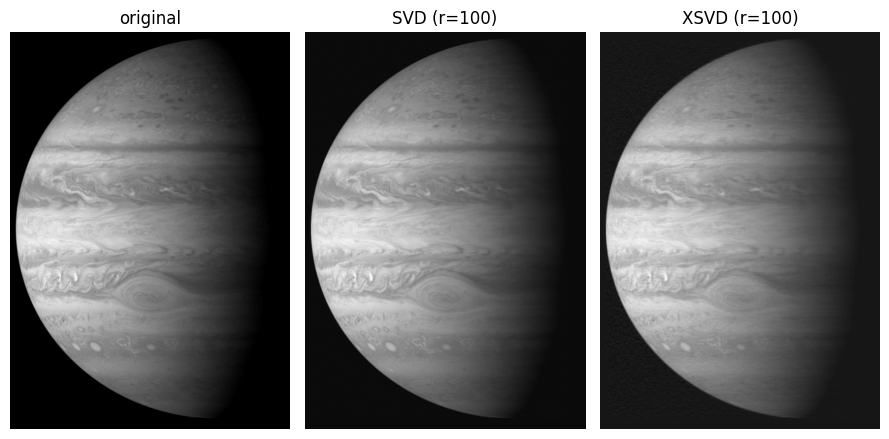

In [ ]:
plt.rcParams['axes.grid'] = False
A       = cv2.imread(os.path.join('data_processing','media','jupiter.png'),0)
X       = np.array(A, float)
U,S,V   = np.linalg.svd(X, full_matrices=False)

r = 100 # Target rank
q = 1   # Power iterations
p = 5   # Oversampling parameter

rU, rS, rV = rsvd(X,r,q,p)

XSVD = U[:,:r] @ np.diag(S[:r]) @ V[:r,:]
#errSVD = np.linalg.norm(X - XSVD, axis = 1)/np.linalg.norm(X, axis = 1)
XrSVD = rU[:,:r] @ np.diag(rS[:r]) @ rV[:r,:]

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(9, 6),tight_layout=True)
titles = ['original',f'SVD (r={r})',f'XSVD (r={r})']
for k, img in enumerate([X,XSVD, XrSVD]):
    ax[k].imshow(img, cmap='gray')
    ax[k].axis('off')
    ax[k].set_title(titles[k])